# Bloque I – Expansión de cobertura  

In [1]:
import glob
import json
import os
from pathlib import Path
import re
import csv

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from nltk.metrics.distance import edit_distance
from sentence_transformers import SentenceTransformer, util

## Métricas

In [2]:
def normalizar_predicado(p):
    return p.replace("_", " ").lower().strip()

In [3]:
def evaluate_structural_similarity_ST(baseline_path, gold_path, threshold=0.8, verbose=False):
    model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2", device="cpu")

    def load_graph(filepath):
        df = pd.read_csv(filepath, sep=';')
        df['predicado'] = df['predicado'].apply(normalizar_predicado)
        nodes = set(df['sujeto']).union(df['objeto'])
        edges = set([tuple(x) for x in df[['sujeto', 'predicado', 'objeto']].values])
        return df, nodes, edges

    def map_entities(pred_entities, gold_entities, model, threshold=0.8):
        pred_list = list(pred_entities)
        gold_list = list(gold_entities)
        pred_emb = model.encode(pred_list, convert_to_tensor=True)
        gold_emb = model.encode(gold_list, convert_to_tensor=True)
        sim_matrix = util.pytorch_cos_sim(pred_emb, gold_emb)
        mapping = {}
        matches = []
        used_gold_nodes = set()
        for i, sims in enumerate(sim_matrix):
            best_score, best_j = sims.max(0)
            if best_score >= threshold:
                pred_term = pred_list[i]
                gold_term = gold_list[best_j.item()]
                if gold_term not in used_gold_nodes:
                    mapping[pred_term] = gold_term
                    used_gold_nodes.add(gold_term)
                    matches.append((pred_term, gold_term, float(best_score)))
                else:
                    mapping[pred_term] = pred_term
            else:
                mapping[pred_list[i]] = pred_list[i]
        return mapping, matches

    def map_edges(pred_edges, gold_edges, model, entity_mapping, threshold=0.8):
        mapped_edges = set()
        gold_edge_list = list(gold_edges)
        matches = []
        used_gold_edges = set()
        for s, p, o in pred_edges:
            s_m = entity_mapping.get(s, s)
            o_m = entity_mapping.get(o, o)
            p_emb = model.encode(p, convert_to_tensor=True)
            found = False
            for gold_s, gold_p, gold_o in gold_edge_list:
                if (gold_s, gold_p, gold_o) in used_gold_edges:
                    continue
                if entity_mapping.get(gold_s, gold_s) != s_m:
                    continue
                if entity_mapping.get(gold_o, gold_o) != o_m:
                    continue
                gold_p_emb = model.encode(gold_p, convert_to_tensor=True)
                sim = util.pytorch_cos_sim(p_emb, gold_p_emb).item()
                if sim >= threshold:
                    mapped_edges.add((s_m, gold_p, o_m))
                    used_gold_edges.add((gold_s, gold_p, gold_o))
                    matches.append(((s, p, o), (gold_s, gold_p, gold_o), float(sim)))
                    found = True
                    break
            if not found:
                mapped_edges.add((s_m, p, o_m))
        return mapped_edges, matches

    df_pred, nodes_pred, edges_pred = load_graph(baseline_path)
    df_gold, nodes_gold, edges_gold = load_graph(gold_path)

    if verbose:
        print("📥 Mapeando nodos...")

    node_mapping, node_matches = map_entities(nodes_pred, nodes_gold, model, threshold)

    if verbose:
        print("📥 Mapeando aristas...")

    mapped_edges, edge_matches = map_edges(edges_pred, edges_gold, model, node_mapping, threshold)
    mapped_nodes = {node_mapping[n] for n in nodes_pred}

    nodes_pred_set = set(mapped_nodes)
    nodes_gold_set = set(nodes_gold)
    edges_pred_set = set(mapped_edges)
    edges_gold_set = set(edges_gold)

    node_inter = nodes_pred_set & nodes_gold_set
    edge_inter = edges_pred_set & edges_gold_set
    node_union = nodes_pred_set | nodes_gold_set
    edge_union = edges_pred_set | edges_gold_set

    similarity = (len(node_inter) + len(edge_inter)) / (len(node_union) + len(edge_union)) if (len(node_union) + len(edge_union)) > 0 else 0.0

    if verbose:
        print("\n✅ Nodos mapeados (pred → gold):")
        for pred, gold, score in node_matches:
            print(f"  {pred} → {gold} (sim={score:.4f})")

        print("\n✅ Aristas mapeadas (pred → gold):")
        for pred_triple, gold_triple, score in edge_matches:
            print(f"  {pred_triple} → {gold_triple} (sim={score:.4f})")

        print(f"\n🧠 Nodos en común ({len(node_inter)}):")
        for n in node_inter:
            print(f"  ✔ {n}")

        print(f"\n➖ Nodos solo en pred ({len(nodes_pred_set - nodes_gold_set)}):")
        for n in nodes_pred_set - nodes_gold_set:
            print(f"  ✖ {n}")

        print(f"\n➖ Nodos solo en gold ({len(nodes_gold_set - nodes_pred_set)}):")
        for n in nodes_gold_set - nodes_pred_set:
            print(f"  ✖ {n}")

        print(f"\n🔗 Aristas en común ({len(edge_inter)}):")
        for e in edge_inter:
            print(f"  ✔ {e}")

        print(f"\n➖ Aristas solo en pred ({len(edges_pred_set - edges_gold_set)}):")
        for e in edges_pred_set - edges_gold_set:
            print(f"  ✖ {e}")

        print(f"\n➖ Aristas solo en gold ({len(edges_gold_set - edges_pred_set)}):")
        for e in edges_gold_set - edges_pred_set:
            print(f"  ✖ {e}")

        print(f"\n📊 Similitud estructural final: {similarity:.4f}")

    return {
      "nodos_en_comun": len(node_inter),
      "aristas_en_comun": len(edge_inter),
      "nodos_totales": len(node_union),
      "aristas_totales": len(edge_union),
      "similitud_estructural": similarity,
      "nodos_pred": nodes_pred_set,
      "nodos_gold": nodes_gold_set,
      "nodos_match": node_inter,
      "aristas_pred": edges_pred_set,
      "aristas_gold": edges_gold_set,
      "aristas_match": edge_inter,
  }

In [4]:
def evaluate_structural_similarity_levenshtein(baseline_path, gold_path, max_distance=2, verbose=False):
    def load_graph(filepath):
        df = pd.read_csv(filepath, sep=';')
        df['predicado'] = df['predicado'].apply(normalizar_predicado)
        nodes = set(df['sujeto']).union(df['objeto'])
        edges = set([tuple(x) for x in df[['sujeto', 'predicado', 'objeto']].values])
        return df, nodes, edges

    def map_entities(pred_entities, gold_entities, max_distance):
        mapping = {}
        matches = []
        used_gold = set()
        for pred in pred_entities:
            best_match = pred
            best_score = float('inf')
            for gold in gold_entities:
                dist = edit_distance(pred.lower(), gold.lower())
                if dist <= max_distance and dist < best_score and gold not in used_gold:
                    best_match = gold
                    best_score = dist
            mapping[pred] = best_match
            if best_match != pred:
                used_gold.add(best_match)
                matches.append((pred, best_match, best_score))
        return mapping, matches

    def map_edges(pred_edges, gold_edges, entity_mapping, max_distance):
        mapped_edges = set()
        used_gold_edges = set()
        matches = []
        for s, p, o in pred_edges:
            s_m = entity_mapping.get(s, s)
            o_m = entity_mapping.get(o, o)
            found = False
            for gs, gp, go in gold_edges:
                if gs != s_m or go != o_m or (gs, gp, go) in used_gold_edges:
                    continue
                dist = edit_distance(p.lower(), gp.lower())
                if dist <= max_distance:
                    mapped_edges.add((s_m, gp, o_m))
                    used_gold_edges.add((gs, gp, go))
                    matches.append(((s, p, o), (gs, gp, go), dist))
                    found = True
                    break
            if not found:
                mapped_edges.add((s_m, p, o_m))
        return mapped_edges, matches

    df_pred, nodes_pred, edges_pred = load_graph(baseline_path)
    df_gold, nodes_gold, edges_gold = load_graph(gold_path)

    if verbose:
        print("📥 Mapeando nodos...")

    node_mapping, node_matches = map_entities(nodes_pred, nodes_gold, max_distance)

    if verbose:
        print("📥 Mapeando aristas...")

    mapped_edges, edge_matches = map_edges(edges_pred, edges_gold, node_mapping, max_distance)
    mapped_nodes = {node_mapping[n] for n in nodes_pred}

    nodes_pred_set = set(mapped_nodes)
    nodes_gold_set = set(nodes_gold)
    edges_pred_set = set(mapped_edges)
    edges_gold_set = set(edges_gold)

    node_inter = nodes_pred_set & nodes_gold_set
    edge_inter = edges_pred_set & edges_gold_set
    node_union = nodes_pred_set | nodes_gold_set
    edge_union = edges_pred_set | edges_gold_set

    similarity = (len(node_inter) + len(edge_inter)) / (len(node_union) + len(edge_union)) if (len(node_union) + len(edge_union)) > 0 else 0.0

    if verbose:
        print("\n✅ Nodos mapeados (pred → gold):")
        for pred, gold, dist in node_matches:
            print(f"  {pred} → {gold} (dist={dist})")

        print("\n✅ Aristas mapeadas (pred → gold):")
        for pred_triple, gold_triple, dist in edge_matches:
            print(f"  {pred_triple} → {gold_triple} (dist={dist})")

        print(f"\n🧠 Nodos en común ({len(node_inter)}):")
        for n in node_inter:
            print(f"  ✔ {n}")

        print(f"\n➖ Nodos solo en pred ({len(nodes_pred_set - nodes_gold_set)}):")
        for n in nodes_pred_set - nodes_gold_set:
            print(f"  ✖ {n}")

        print(f"\n➖ Nodos solo en gold ({len(nodes_gold_set - nodes_pred_set)}):")
        for n in nodes_gold_set - nodes_pred_set:
            print(f"  ✖ {n}")

        print(f"\n🔗 Aristas en común ({len(edge_inter)}):")
        for e in edge_inter:
            print(f"  ✔ {e}")

        print(f"\n➖ Aristas solo en pred ({len(edges_pred_set - edges_gold_set)}):")
        for e in edges_pred_set - edges_gold_set:
            print(f"  ✖ {e}")

        print(f"\n➖ Aristas solo en gold ({len(edges_gold_set - edges_pred_set)}):")
        for e in edges_gold_set - edges_pred_set:
            print(f"  ✖ {e}")

        print(f"\n📊 Similitud estructural final: {similarity:.4f}")

    return {
      "nodos_en_comun": len(node_inter),
      "aristas_en_comun": len(edge_inter),
      "nodos_totales": len(node_union),
      "aristas_totales": len(edge_union),
      "similitud_estructural": similarity,
      "nodos_pred": nodes_pred_set,
      "nodos_gold": nodes_gold_set,
      "nodos_match": node_inter,
      "aristas_pred": edges_pred_set,
      "aristas_gold": edges_gold_set,
      "aristas_match": edge_inter,
  }

In [5]:
def calculate_accuracy_ST(gold_path, generated_path, threshold=0.8):
    results = evaluate_structural_similarity_ST(generated_path, gold_path, threshold)
    edge_accuracy = len(results["aristas_match"]) / len(results["aristas_pred"]) if results["aristas_pred"] else 0.0
    node_accuracy = len(results["nodos_match"]) / len(results["nodos_pred"]) if results["nodos_pred"] else 0.0
    return (edge_accuracy + node_accuracy) / 2

def calculate_recall_ST(gold_path, generated_path, threshold=0.8):
    results = evaluate_structural_similarity_ST(generated_path, gold_path, threshold)
    edge_recall = len(results["aristas_match"]) / len(results["aristas_gold"]) if results["aristas_gold"] else 0.0
    node_recall = len(results["nodos_match"]) / len(results["nodos_gold"]) if results["nodos_gold"] else 0.0
    return (edge_recall + node_recall) / 2

In [6]:
def calculate_accuracy_levenshtein(gold_path, generated_path, max_distance=2):
    results = evaluate_structural_similarity_levenshtein(generated_path, gold_path, max_distance)
    edge_accuracy = len(results["aristas_match"]) / len(results["aristas_pred"]) if results["aristas_pred"] else 0.0
    node_accuracy = len(results["nodos_match"]) / len(results["nodos_pred"]) if results["nodos_pred"] else 0.0
    return (edge_accuracy + node_accuracy) / 2

def calculate_recall_levenshtein(gold_path, generated_path, max_distance=2):
    results = evaluate_structural_similarity_levenshtein(generated_path, gold_path, max_distance)
    edge_recall = len(results["aristas_match"]) / len(results["aristas_gold"]) if results["aristas_gold"] else 0.0
    node_recall = len(results["nodos_match"]) / len(results["nodos_gold"]) if results["nodos_gold"] else 0.0
    return (edge_recall + node_recall) / 2

In [7]:
def evaluar_grafo(gold_path, generated_path, version_name, threshold_st=0.8, max_dist_lev=2):
    acc_st = calculate_accuracy_ST(gold_path, generated_path, threshold=threshold_st)
    recall_st = calculate_recall_ST(gold_path, generated_path, threshold=threshold_st)
    f1_st = (2 * acc_st * recall_st) / (acc_st + recall_st) if (acc_st + recall_st) > 0 else 0.0

    acc_lev = calculate_accuracy_levenshtein(gold_path, generated_path, max_distance=max_dist_lev)
    recall_lev = calculate_recall_levenshtein(gold_path, generated_path, max_distance=max_dist_lev)
    f1_lev = (2 * acc_lev * recall_lev) / (acc_lev + recall_lev) if (acc_lev + recall_lev) > 0 else 0.0

    jaccard_st = evaluate_structural_similarity_ST(generated_path, gold_path, threshold=threshold_st)["similitud_estructural"]
    jaccard_lev = evaluate_structural_similarity_levenshtein(generated_path, gold_path, max_distance=max_dist_lev)["similitud_estructural"]

    df = pd.DataFrame([{
        "versión": version_name,
        "accuracy_ST": acc_st,
        "accuracy_Levenshtein": acc_lev,
        "recall_ST": recall_st,
        "recall_Levenshtein": recall_lev,
        "f1_ST": f1_st,
        "f1_Levenshtein": f1_lev,
        "jaccard_ST": jaccard_st,
        "jaccard_Levenshtein": jaccard_lev
    }])

    return df


In [8]:
def plot_comparison_bars(df, title, colors=None):

    metrics = ["accuracy_ST", "accuracy_Levenshtein",
               "recall_ST", "recall_Levenshtein",
               "f1_ST", "f1_Levenshtein",
               "jaccard_ST", "jaccard_Levenshtein"]

    labels = ["Acc ST", "Acc Lev",
              "Rec ST", "Rec Lev",
              "F1 ST", "F1 Lev",
              "Jac ST", "Jac Lev"]

    versions = df["versión"].tolist()
    n_versions = len(versions)
    x = np.arange(len(metrics))
    width = 0.8 / n_versions

    default_colors = ['#ff7f0e', '#1f77b4', '#d62728', '#9467bd',
                      '#2ca02c', '#f0e442', '#e377c2', '#7f7f7f',
                      '#8c564b', '#17becf', '#bcbd22', '#393b79']

    if colors is None:
        colors = default_colors

    fig, ax = plt.subplots(figsize=(12, 6))
    for i, version in enumerate(versions):
        values = [df.loc[i, m] for m in metrics]
        positions = x - 0.4 + width/2 + i * width
        bars = ax.bar(
            positions, values, width,
            label=version,
            color=colors[i % len(colors)],
            edgecolor='black',
            alpha=0.85
        )
        for bar in bars:
            h = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, h + 0.01, f"{h:.2f}",
                    ha='center', va='bottom', fontsize=9)

    ax.set_xticks(x)
    ax.set_xticklabels(labels, fontsize=10, fontweight='medium', rotation=25)
    max_val = max(df[metrics].max())
    ax.set_ylim(0, max_val * 1.50)
    ax.set_ylabel("Metric Value", fontsize=12)
    ax.set_title(title, fontsize=14, pad=20)
    ax.yaxis.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
    ax.set_axisbelow(True)
    ax.legend(frameon=False, fontsize=11, loc='upper right')
    plt.tight_layout()
    plt.show()

## Estrategia 1: Normalización por Chunking y Re-Extracción

1. Se aplica la normalización por chunking, en la que cada sintagma nominal del texto de referencia se convierte en una unidad léxica indivisible uniendo sus palabras con guiones bajos

In [9]:
def normalize_concept(concept):
    return re.sub(r'\W+', '_', concept.strip().lower())

def replace_concepts_in_text(json_path, text_path, output_path):
    data = json.load(open(json_path, 'r', encoding='utf-8'))
    concepts = sorted(
        {c for entry in data for c in entry.get("concepts_cleaned", [])},
        key=len, reverse=True
    )
    text = Path(text_path).read_text(encoding='utf-8')
    for concept in concepts:
        pattern = re.compile(r'\b' + re.escape(concept) + r'\b', flags=re.IGNORECASE)
        text = pattern.sub(normalize_concept(concept), text)
    output_path.parent.mkdir(parents=True, exist_ok=True)
    output_path.write_text(text, encoding='utf-8')
    print(f"Generated {output_path}")

input_dir = Path("/content/Cleaned")
text_dir = Path("/content")
output_dir = Path("/content/ReplacedTexts")

files = [
    ("Ellipse_concepts_cleaned.json",    "Ellipse.txt",        "Ellipse_cleaned.txt"),
    ("Homeostasis_concepts_cleaned.json","Homeostasis.txt",    "Homeostasis_cleaned.txt"),
    ("Inflation_concepts_cleaned.json",  "Inflation.txt",      "Inflation_cleaned.txt"),
    ("Utilitarianism_concepts_cleaned.json","Utilitarianism.txt","Utilitarianism_cleaned.txt"),
]

for json_file, txt_file, out_file in files:
    replace_concepts_in_text(
        input_dir / json_file,
        text_dir / txt_file,
        output_dir / out_file
    )

Generated /content/ReplacedTexts/Ellipse_cleaned.txt
Generated /content/ReplacedTexts/Homeostasis_cleaned.txt
Generated /content/ReplacedTexts/Inflation_cleaned.txt
Generated /content/ReplacedTexts/Utilitarianism_cleaned.txt


2. Sobre el texto así transformado se realiza la re-extracción de tripletas con OpenIE. Se obtienen los CSVs de la carpeta S1.

In [10]:
s1_dir = Path("/content/S1")
baseline_dir = Path("/content")
output_dir = Path("/content/Transformation_1")
output_dir.mkdir(parents=True, exist_ok=True)

cols = ["sujeto", "predicado", "objeto"]
names = ["Utilitarianism", "Ellipse", "Homeostasis", "Inflation"]

for name in names:
    base_path = baseline_dir / f"{name}_Baseline.csv"
    df_base = pd.read_csv(base_path, sep=";")
    for c in cols:
        df_base[c] = df_base[c].str.lower()
    base_triples = {(r.sujeto, r.predicado, r.objeto) for r in df_base.itertuples(index=False)}
    orig_count = len(base_triples)

    s1_path = s1_dir / f"{name}_S1.csv"
    df_s1 = pd.read_csv(s1_path, sep=";")
    for c in cols:
        df_s1[c] = df_s1[c].str.replace("_", " ", regex=False)
    s1_triples = {(r.sujeto, r.predicado, r.objeto) for r in df_s1.itertuples(index=False)}

    new_triples = s1_triples - base_triples
    new_count = len(new_triples)
    percent_added = (new_count / orig_count * 100) if orig_count else 0.0

    df_new = df_s1[df_s1.apply(lambda r: (r.sujeto, r.predicado, r.objeto) in new_triples, axis=1)]

    print(f"\n=== {name} ===")
    print(f"Tripletas en baseline antes: {orig_count}")
    print(f"Tripletas nuevas detectadas: {new_count} ({percent_added:.2f}%)")
    if new_count:
        print("Se añaden:")
        for r in df_new.itertuples(index=False):
            print(f"  - ({r.sujeto!r}, {r.predicado!r}, {r.objeto!r})")
    else:
        print("No hay tripletas nuevas.")

    df_out = pd.concat([df_base, df_new], ignore_index=True)
    out_path = output_dir / f"{name}_Transformation_1.csv"
    df_out.to_csv(out_path, sep=";", index=False)
    print(f"Archivo generado: {out_path}")


=== Utilitarianism ===
Tripletas en baseline antes: 52
Tripletas nuevas detectadas: 11 (21.15%)
Se añaden:
  - ('utilitarianism', 'be one', 'most powerful and persuasive approaches to normative ethics in the history of philosophy')
  - ('utilitarianism', 'be one', 'powerful and persuasive approaches to normative ethics in the history of philosophy')
  - ('utilitarianism', 'be one of', 'most powerful and persuasive approaches to normative ethics in the history of philosophy')
  - ('utilitarianism', 'be one of', 'powerful and persuasive approaches to normative ethics in the history of philosophy')
  - ('proto utilitarian positions', 'articulate until', '19th century')
  - ('proto utilitarian positions', 'can', 'can discern throughout history of ethical theory')
  - ('proto utilitarian positions', 'can', 'can discern')
  - ('proto utilitarian positions', 'fully articulate until', '19th century')
  - ('morally right action', 'be', 'action')
  - ('one', 'ought on', 'utilitarian view')
  - 



### Estrategia 1: Métricas

####  Análisis por texto

In [11]:
gold_paths = {
    "utilitarianism": "/content/Utilitarianism_Gold.csv",
    "ellipse": "/content/Ellipse_Gold.csv",
    "homeostasis": "/content/Homeostasis_Gold.csv",
    "inflation": "/content/Inflation_Gold.csv"
}
paths_t1 = {
    "utilitarianism": (
        "/content/Utilitarianism_Baseline.csv",
        "/content/Transformation_1/Utilitarianism_Transformation_1.csv"
    ),
    "ellipse": (
        "/content/Ellipse_Baseline.csv",
        "/content/Transformation_1/Ellipse_Transformation_1.csv"
    ),
    "homeostasis": (
        "/content/Homeostasis_Baseline.csv",
        "/content/Transformation_1/Homeostasis_Transformation_1.csv"
    ),
    "inflation": (
        "/content/Inflation_Baseline.csv",
        "/content/Transformation_1/Inflation_Transformation_1.csv"
    )
}

# 1) Utilitarianism
df_utilitarianism_t1 = pd.concat([
    evaluar_grafo(gold_paths["utilitarianism"], paths_t1["utilitarianism"][0], "Baseline"),
    evaluar_grafo(gold_paths["utilitarianism"], paths_t1["utilitarianism"][1], "Transformación 1")
], ignore_index=True)

# 2) Ellipse
df_ellipse_t1 = pd.concat([
    evaluar_grafo(gold_paths["ellipse"], paths_t1["ellipse"][0], "Baseline"),
    evaluar_grafo(gold_paths["ellipse"], paths_t1["ellipse"][1], "Transformación 1")
], ignore_index=True)

# 3) Homeostasis
df_homeostasis_t1 = pd.concat([
    evaluar_grafo(gold_paths["homeostasis"], paths_t1["homeostasis"][0], "Baseline"),
    evaluar_grafo(gold_paths["homeostasis"], paths_t1["homeostasis"][1], "Transformación 1")
], ignore_index=True)

# 4) Inflation
df_inflation_t1 = pd.concat([
    evaluar_grafo(gold_paths["inflation"], paths_t1["inflation"][0], "Baseline"),
    evaluar_grafo(gold_paths["inflation"], paths_t1["inflation"][1], "Transformación 1")
], ignore_index=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2/resolve/main/modules.json
Retrying in 1s [Retry 1/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2/resolve/main/modules.json
Retrying in 2s [Retry 2/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2/resolve/main/modules.json
Retrying in 4s [Retry 3/5].
HT

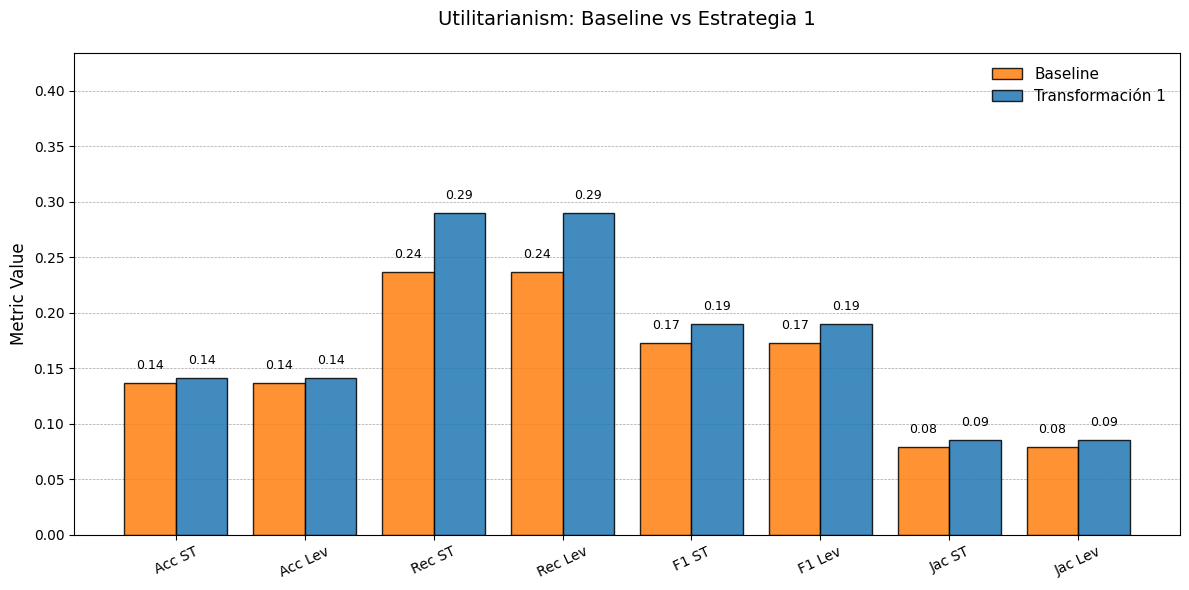

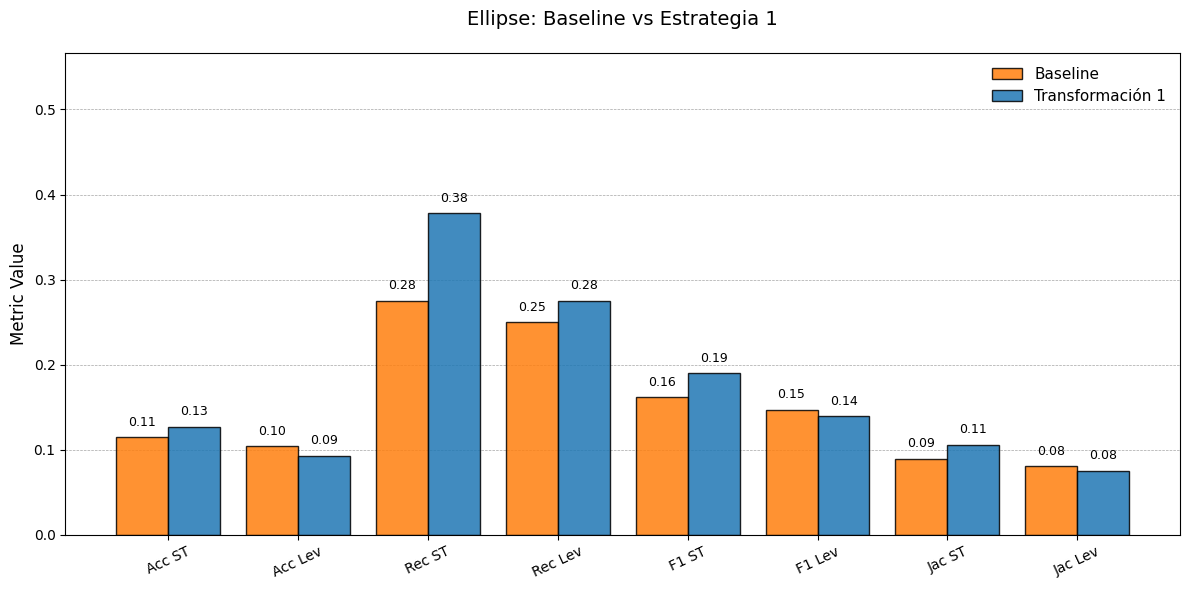

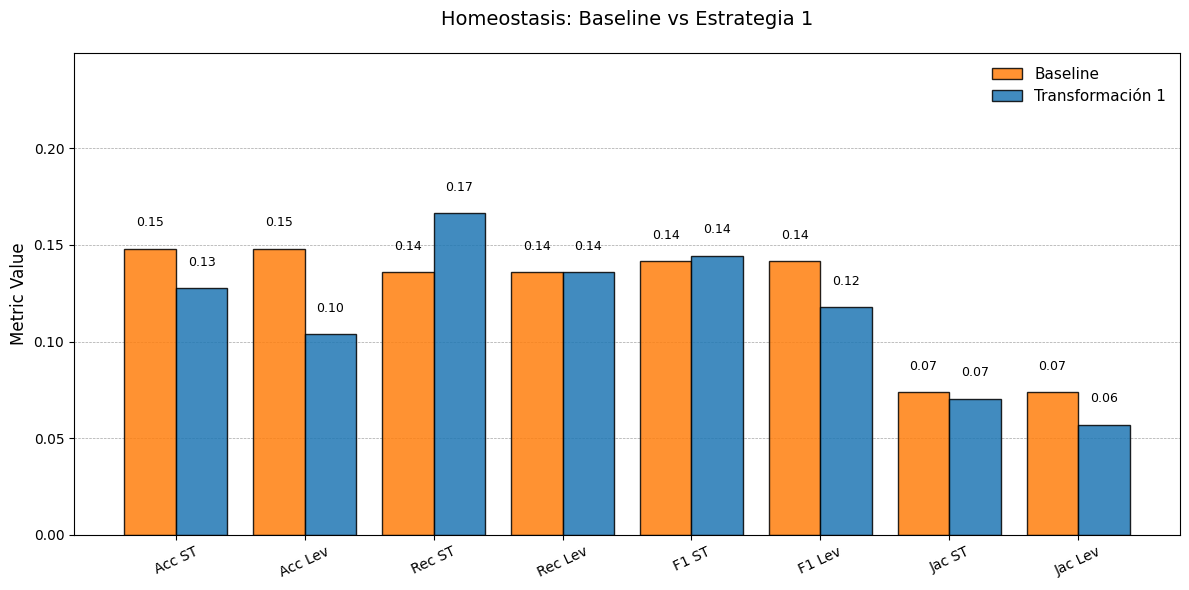

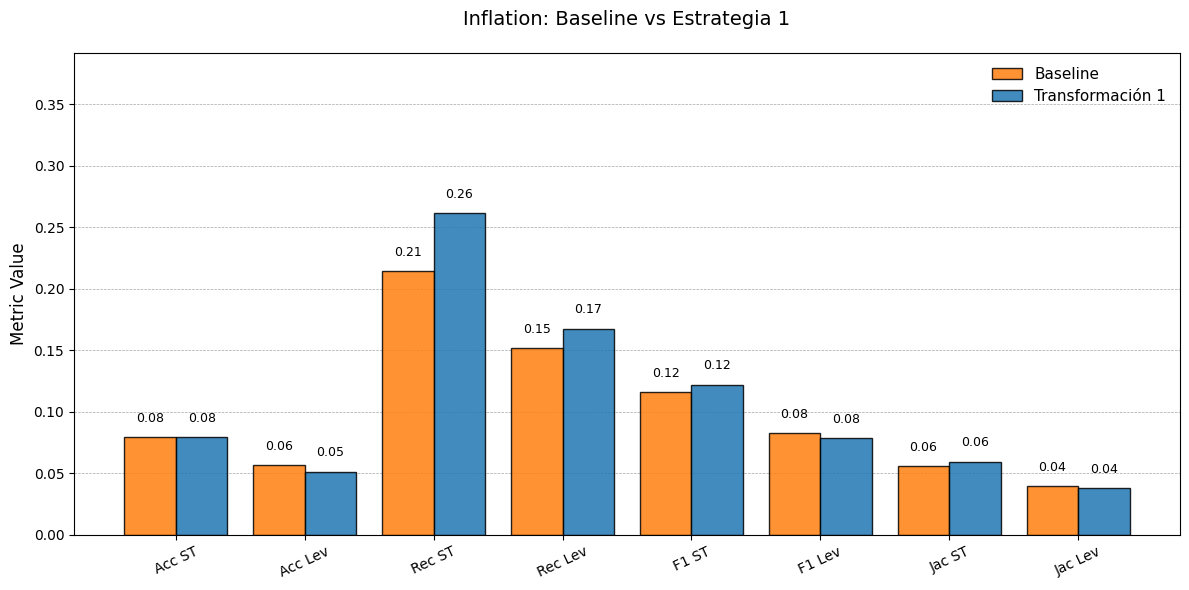

In [12]:
custom_colors = ['#ff7f0e', '#1f77b4']

plot_comparison_bars(df_utilitarianism_t1, "Utilitarianism: Baseline vs Estrategia 1", colors=custom_colors)
plot_comparison_bars(df_ellipse_t1, "Ellipse: Baseline vs Estrategia 1", colors=custom_colors)
plot_comparison_bars(df_homeostasis_t1, "Homeostasis: Baseline vs Estrategia 1", colors=custom_colors)
plot_comparison_bars(df_inflation_t1, "Inflation: Baseline vs Estrategia 1", colors=custom_colors)

In [13]:
df_utilitarianism_t1

,versión,accuracy_ST,accuracy_Levenshtein,recall_ST,recall_Levenshtein,f1_ST,f1_Levenshtein,jaccard_ST,jaccard_Levenshtein
0,Baseline,0.136364,0.136364,0.236842,0.236842,0.173077,0.173077,0.078947,0.078947
1,Transformación 1,0.141026,0.141026,0.289474,0.289474,0.189655,0.189655,0.085271,0.085271


In [14]:
df_ellipse_t1

,versión,accuracy_ST,accuracy_Levenshtein,recall_ST,recall_Levenshtein,f1_ST,f1_Levenshtein,jaccard_ST,jaccard_Levenshtein
0,Baseline,0.114583,0.104167,0.275000,0.250,0.161765,0.147059,0.089431,0.080645
1,Transformación 1,0.126977,0.093220,0.377778,0.275,0.190069,0.139241,0.105634,0.075342


In [15]:
df_homeostasis_t1

,versión,accuracy_ST,accuracy_Levenshtein,recall_ST,recall_Levenshtein,f1_ST,f1_Levenshtein,jaccard_ST,jaccard_Levenshtein
0,Baseline,0.148039,0.148039,0.135918,0.135918,0.141720,0.141720,0.073770,0.073770
1,Transformación 1,0.127668,0.103859,0.166221,0.135918,0.144416,0.117745,0.070513,0.056962


In [16]:
df_inflation_t1

,versión,accuracy_ST,accuracy_Levenshtein,recall_ST,recall_Levenshtein,f1_ST,f1_Levenshtein,jaccard_ST,jaccard_Levenshtein
0,Baseline,0.079663,0.056675,0.214489,0.151989,0.116177,0.082563,0.056000,0.039370
1,Transformación 1,0.079638,0.051336,0.261364,0.167614,0.122079,0.078600,0.059649,0.037801


#### Evolución media de métricas

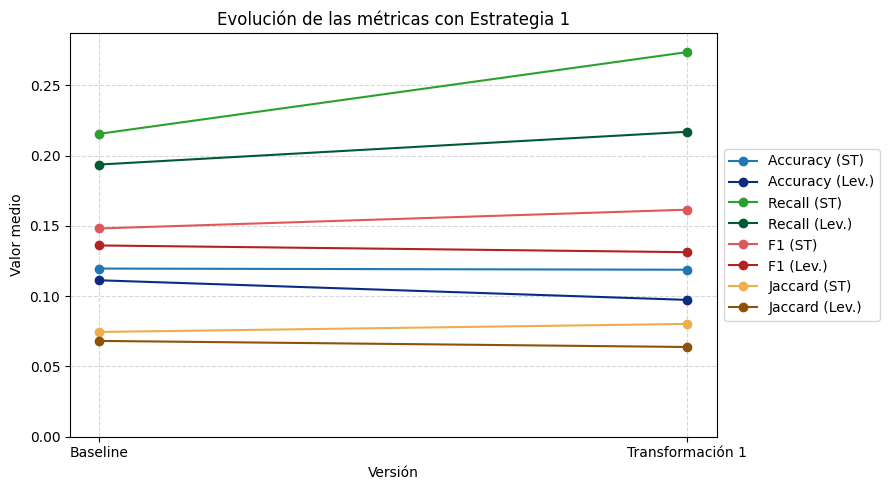

In [17]:
df_t1_all = pd.concat([
    df_utilitarianism_t1.assign(texto="Utilitarianism"),
    df_ellipse_t1.assign(texto="Ellipse"),
    df_homeostasis_t1.assign(texto="Homeostasis"),
    df_inflation_t1.assign(texto="Inflation"),
], ignore_index=True)

df_t1_summary = df_t1_all.groupby("versión")[
    ["accuracy_ST","accuracy_Levenshtein",
     "recall_ST","recall_Levenshtein",
     "f1_ST", "f1_Levenshtein",
     "jaccard_ST","jaccard_Levenshtein"]
].mean().reset_index()

metrics = [
    "accuracy_ST",
    "accuracy_Levenshtein",
    "recall_ST",
    "recall_Levenshtein",
    "f1_ST",
    "f1_Levenshtein",
    "jaccard_ST",
    "jaccard_Levenshtein"
]

labels = [
    "Accuracy (ST)",
    "Accuracy (Lev.)",
    "Recall (ST)",
    "Recall (Lev.)",
    "F1 (ST)",
    "F1 (Lev.)",
    "Jaccard (ST)",
    "Jaccard (Lev.)"
]

color_map = {
    "accuracy_ST":          "#1f77b4",
    "accuracy_Levenshtein": "#0c2c84",
    "recall_ST":            "#2ca02c",
    "recall_Levenshtein":   "#005a32",
    "f1_ST":                "#e15759",
    "f1_Levenshtein":       "#B22222",
    "jaccard_ST":           "#f0ad4e",
    "jaccard_Levenshtein":  "#8c510a"
}


metrics = list(color_map.keys())

max_val = df_t1_summary[metrics].max().max()

plt.figure(figsize=(9, 5))
for m, lbl in zip(metrics, labels):
    plt.plot(df_t1_summary["versión"], df_t1_summary[m],
             marker="o", label=lbl, color=color_map[m])

plt.ylim(0, max_val * 1.05)
plt.xlabel("Versión")
plt.ylabel("Valor medio")
plt.title("Evolución de las métricas con Estrategia 1")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

In [18]:
df_t1_summary

,versión,accuracy_ST,accuracy_Levenshtein,recall_ST,recall_Levenshtein,f1_ST,f1_Levenshtein,jaccard_ST,jaccard_Levenshtein
0,Baseline,0.119662,0.111311,0.215562,0.193687,0.148185,0.136105,0.074537,0.068183
1,Transformación 1,0.118827,0.097360,0.273709,0.217001,0.161555,0.131310,0.080267,0.063844


## Estrategia 2: Extracción de tripletas de chunks con verbos

1. Se recogen todos los chunks marcados como verbales y se procesan con el extractor de tripletas de OpenIE como oraciones independientes.

In [19]:
csv_files = glob.glob('/content/ChunksWithVerbsTriplets/*_chunks_with_verbs_triplets.csv')

for path in csv_files:
    df = pd.read_csv(path, sep=';')

    print(f"\n--- Tripletas en {path} ---")
    for _, row in df.iterrows():
        sujeto = row['sujeto']
        predicado = row['predicado']
        objeto = row['objeto']
        print(f"{sujeto} | {predicado} | {objeto}")


--- Tripletas en /content/ChunksWithVerbsTriplets/Utilitarianism_chunks_with_verbs_triplets.csv ---
way | spell out | general claim
way | spell out | claim

--- Tripletas en /content/ChunksWithVerbsTriplets/Homeostasis_chunks_with_verbs_triplets.csv ---
fluid | bath | cell
interstitial fluid | bath | cell
know homeostatic mechanism | be in | human
many other homeostatic mechanism | entity in | body
control other entity | be in | body

--- Tripletas en /content/ChunksWithVerbsTriplets/Ellipse_chunks_with_verbs_triplets.csv ---
cardboard | form | focus
cardboard | form | focus of ellipse
curve | be with | pencil

--- Tripletas en /content/ChunksWithVerbsTriplets/Inflation_chunks_with_verbs_triplets.csv ---
overall demand | be in | economy
economy | have | ability to supply
overall demand | be in | economy
economy | have | ability to supply
economy | have | ability to supply
increase | lead to | surge demand
surge | be in | demand
increase | be in | consumer spending
increase | lead to |

2. Se añaden estas nuevas tripletas a las tripletas del baseline

In [20]:
def remove_spo_duplicates(df, name):
    before = len(df)
    key = df['sujeto'] + df['predicado'] + df['objeto']
    df_dedup = df.loc[key.drop_duplicates().index].reset_index(drop=True)
    removed = before - len(df_dedup)
    print(f'{name}: removed {removed}')
    return df_dedup

In [21]:
def merge_triplets(df1_path, df2_path, output_path):
    df1 = pd.read_csv(df1_path, sep=";")
    df2 = pd.read_csv(df2_path, sep=";")
    df_combined = pd.concat([df1, df2], ignore_index=True)
    before = len(df_combined)
    df_combined = df_combined.drop_duplicates(subset=['sujeto', 'predicado', 'objeto'])
    removed = before - len(df_combined)
    print(f"Removed {removed} duplicate rows")
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    df_combined.to_csv(output_path, sep=";", index=False, quoting=1, quotechar='"')
    print(f"✅ Combinado y guardado: {output_path}")

In [22]:
merge_triplets(
    "/content/Utilitarianism_Baseline.csv",
    "/content/ChunksWithVerbsTriplets/Utilitarianism_chunks_with_verbs_triplets.csv",
    "/content/Transformation_2/Utilitarianism_Transformation_2.csv"
)

merge_triplets(
    "/content/Ellipse_Baseline.csv",
    "/content/ChunksWithVerbsTriplets/Ellipse_chunks_with_verbs_triplets.csv",
    "/content/Transformation_2/Ellipse_Transformation_2.csv"
)

merge_triplets(
    "/content/Homeostasis_Baseline.csv",
    "/content/ChunksWithVerbsTriplets/Homeostasis_chunks_with_verbs_triplets.csv",
    "/content/Transformation_2/Homeostasis_Transformation_2.csv"
)

merge_triplets(
    "/content/Inflation_Baseline.csv",
    "/content/ChunksWithVerbsTriplets/Inflation_chunks_with_verbs_triplets.csv",
    "/content/Transformation_2/Inflation_Transformation_2.csv"
)

Removed 0 duplicate rows
✅ Combinado y guardado: /content/Transformation_2/Utilitarianism_Transformation_2.csv
Removed 0 duplicate rows
✅ Combinado y guardado: /content/Transformation_2/Ellipse_Transformation_2.csv
Removed 2 duplicate rows
✅ Combinado y guardado: /content/Transformation_2/Homeostasis_Transformation_2.csv
Removed 10 duplicate rows
✅ Combinado y guardado: /content/Transformation_2/Inflation_Transformation_2.csv


### Estrategia 2: Métricas

#### Análisis por texto

In [23]:
paths_t2 = {
    "utilitarianism": (
        "/content/Utilitarianism_Baseline.csv",
        "/content/Transformation_2/Utilitarianism_Transformation_2.csv"
    ),
    "ellipse": (
        "/content/Ellipse_Baseline.csv",
        "/content/Transformation_2/Ellipse_Transformation_2.csv"
    ),
    "homeostasis": (
        "/content/Homeostasis_Baseline.csv",
        "/content/Transformation_2/Homeostasis_Transformation_2.csv"
    ),
    "inflation": (
        "/content/Inflation_Baseline.csv",
        "/content/Transformation_2/Inflation_Transformation_2.csv"
    )
}


# 1) Utilitarianism
df_utilitarianism_t2 = pd.concat([
    evaluar_grafo(gold_paths["utilitarianism"], paths_t2["utilitarianism"][0], "Baseline"),
    evaluar_grafo(gold_paths["utilitarianism"], paths_t2["utilitarianism"][1], "Transformación 2")
], ignore_index=True)

# 2) Ellipse
df_ellipse_t2 = pd.concat([
    evaluar_grafo(gold_paths["ellipse"], paths_t2["ellipse"][0], "Baseline"),
    evaluar_grafo(gold_paths["ellipse"], paths_t2["ellipse"][1], "Transformación 2")
], ignore_index=True)

# 3) Homeostasis
df_homeostasis_t2 = pd.concat([
    evaluar_grafo(gold_paths["homeostasis"], paths_t2["homeostasis"][0], "Baseline"),
    evaluar_grafo(gold_paths["homeostasis"], paths_t2["homeostasis"][1], "Transformación 2")
], ignore_index=True)

# 4) Inflation
df_inflation_t2 = pd.concat([
    evaluar_grafo(gold_paths["inflation"], paths_t2["inflation"][0], "Baseline"),
    evaluar_grafo(gold_paths["inflation"], paths_t2["inflation"][1], "Transformación 2")
], ignore_index=True)

HTTP Error 429 thrown while requesting HEAD https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2/resolve/main/modules.json
Retrying in 1s [Retry 1/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2/resolve/main/modules.json
Retrying in 2s [Retry 2/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2/resolve/main/modules.json
Retrying in 4s [Retry 3/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2/resolve/main/modules.json
Retrying in 8s [Retry 4/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2/resolve/main/modules.json
Retrying in 8s [Retry 5/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2/resolve/main/modules.json
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/s

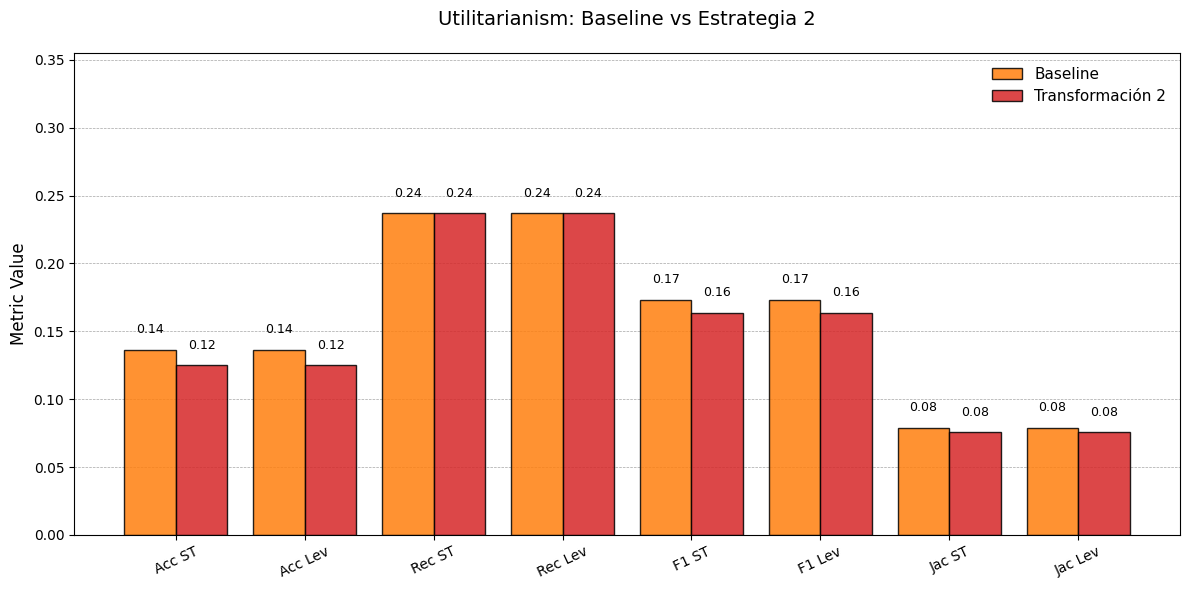

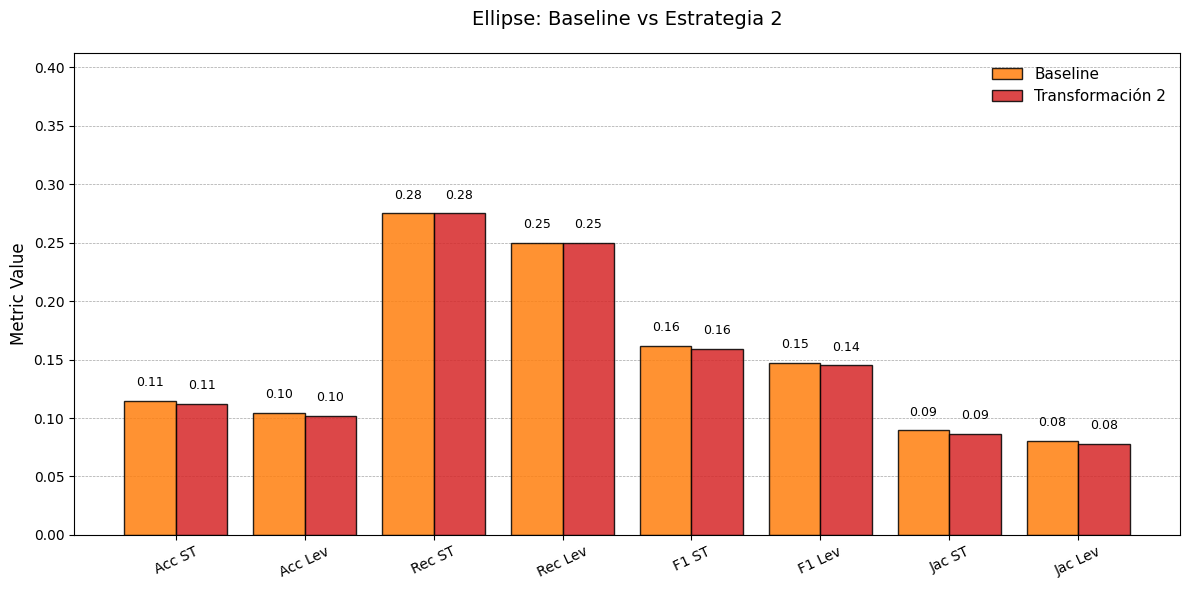

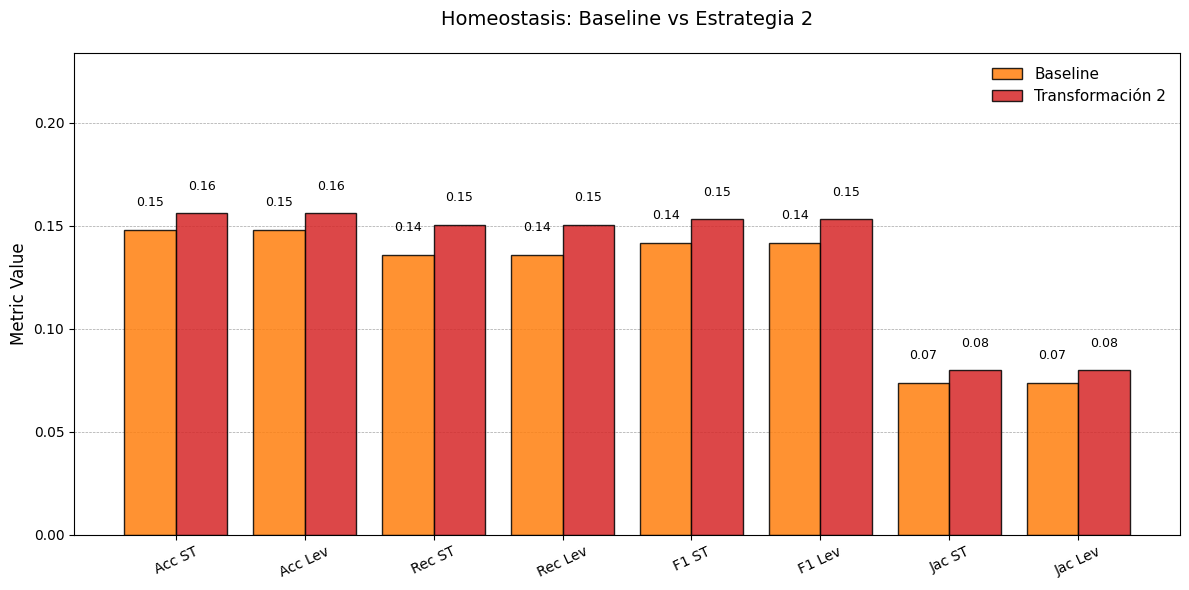

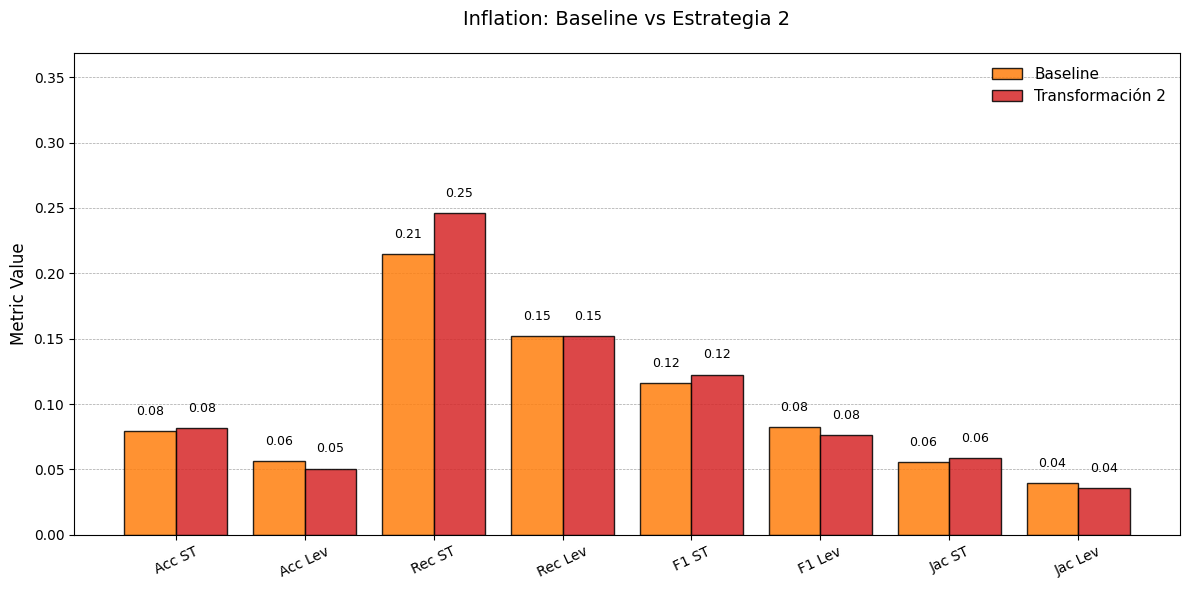

In [24]:
custom_colors = ['#ff7f0e', '#d62728']

plot_comparison_bars(df_utilitarianism_t2, "Utilitarianism: Baseline vs Estrategia 2", colors=custom_colors)
plot_comparison_bars(df_ellipse_t2, "Ellipse: Baseline vs Estrategia 2", colors=custom_colors)
plot_comparison_bars(df_homeostasis_t2, "Homeostasis: Baseline vs Estrategia 2", colors=custom_colors)
plot_comparison_bars(df_inflation_t2, "Inflation: Baseline vs Estrategia 2", colors=custom_colors)

In [25]:
df_utilitarianism_t2

,versión,accuracy_ST,accuracy_Levenshtein,recall_ST,recall_Levenshtein,f1_ST,f1_Levenshtein,jaccard_ST,jaccard_Levenshtein
0,Baseline,0.136364,0.136364,0.236842,0.236842,0.173077,0.173077,0.078947,0.078947
1,Transformación 2,0.125000,0.125000,0.236842,0.236842,0.163636,0.163636,0.075630,0.075630


In [26]:
df_ellipse_t2

,versión,accuracy_ST,accuracy_Levenshtein,recall_ST,recall_Levenshtein,f1_ST,f1_Levenshtein,jaccard_ST,jaccard_Levenshtein
0,Baseline,0.114583,0.104167,0.275,0.25,0.161765,0.147059,0.089431,0.080645
1,Transformación 2,0.112245,0.102041,0.275,0.25,0.159420,0.144928,0.086614,0.078125


In [27]:
df_homeostasis_t2

,versión,accuracy_ST,accuracy_Levenshtein,recall_ST,recall_Levenshtein,f1_ST,f1_Levenshtein,jaccard_ST,jaccard_Levenshtein
0,Baseline,0.148039,0.148039,0.135918,0.135918,0.141720,0.141720,0.07377,0.07377
1,Transformación 2,0.156059,0.156059,0.150624,0.150624,0.153293,0.153293,0.08000,0.08000


In [28]:
df_inflation_t2

,versión,accuracy_ST,accuracy_Levenshtein,recall_ST,recall_Levenshtein,f1_ST,f1_Levenshtein,jaccard_ST,jaccard_Levenshtein
0,Baseline,0.079663,0.056675,0.214489,0.151989,0.116177,0.082563,0.056000,0.039370
1,Transformación 2,0.081667,0.050740,0.245739,0.151989,0.122593,0.076081,0.058824,0.035971


#### Evolución media de métricas

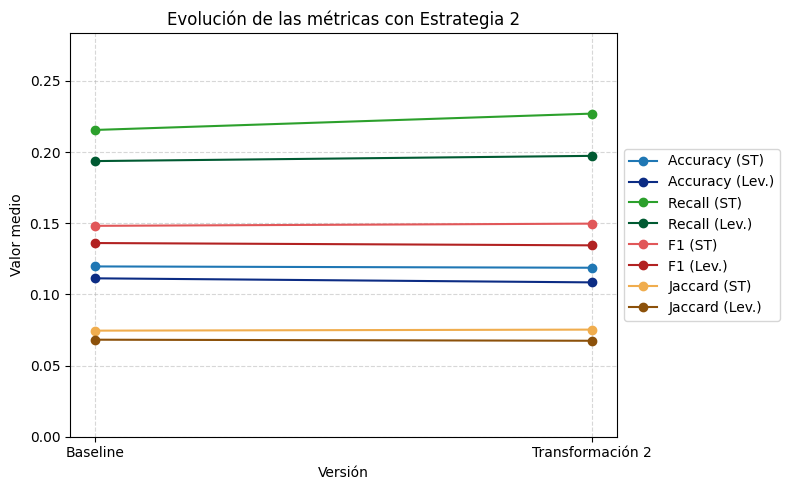

In [29]:
df_t2_all = pd.concat([
    df_utilitarianism_t2.assign(texto="Utilitarianism"),
    df_ellipse_t2.assign(texto="Ellipse"),
    df_homeostasis_t2.assign(texto="Homeostasis"),
    df_inflation_t2.assign(texto="Inflation"),
], ignore_index=True)

df_t2_summary = df_t2_all.groupby("versión")[
    ["accuracy_ST","accuracy_Levenshtein",
     "recall_ST","recall_Levenshtein",
     "f1_ST", "f1_Levenshtein",
     "jaccard_ST","jaccard_Levenshtein"]
].mean().reset_index()

metrics = [
    "accuracy_ST",
    "accuracy_Levenshtein",
    "recall_ST",
    "recall_Levenshtein",
    "f1_ST",
    "f1_Levenshtein",
    "jaccard_ST",
    "jaccard_Levenshtein"
]

labels = [
    "Accuracy (ST)",
    "Accuracy (Lev.)",
    "Recall (ST)",
    "Recall (Lev.)",
    "F1 (ST)",
    "F1 (Lev.)",
    "Jaccard (ST)",
    "Jaccard (Lev.)"
]

max_val = df_t2_summary[metrics].max().max()

plt.figure(figsize=(8, 5))
for m, lbl in zip(metrics, labels):
    plt.plot(df_t2_summary["versión"], df_t2_summary[m], marker="o", label=lbl, color=color_map[m])

plt.ylim(0, max_val * 1.25)
plt.xlabel("Versión")
plt.ylabel("Valor medio")
plt.title("Evolución de las métricas con Estrategia 2")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


In [30]:
df_t2_summary

,versión,accuracy_ST,accuracy_Levenshtein,recall_ST,recall_Levenshtein,f1_ST,f1_Levenshtein,jaccard_ST,jaccard_Levenshtein
0,Baseline,0.119662,0.111311,0.215562,0.193687,0.148185,0.136105,0.074537,0.068183
1,Transformación 2,0.118743,0.108460,0.227051,0.197364,0.149736,0.134484,0.075267,0.067432


## Evaluación Bloque I

In [31]:
def merge_and_report(baseline_path, s1_path, s2_path):
    baseline = pd.read_csv(baseline_path, sep=None, engine='python')
    s1 = pd.read_csv(s1_path, sep=None, engine='python')
    s2 = pd.read_csv(s2_path, sep=None, engine='python')
    merged = pd.concat([baseline, s1, s2], ignore_index=True)
    print(f'baseline {len(baseline)}, s1 {len(s1)}, s2 {len(s2)}, total {len(merged)}')
    return merged

def remove_spo_duplicates(df, name):
    before = len(df)
    key = df['sujeto'] + df['predicado'] + df['objeto']
    df_dedup = df.loc[key.drop_duplicates().index].reset_index(drop=True)
    removed = before - len(df_dedup)
    print(f'{name}: removed {removed}')
    return df_dedup

os.makedirs('/content/Transformation_1_2', exist_ok=True)

for name in ['Utilitarianism', 'Ellipse', 'Homeostasis', 'Inflation']:
    print(name)
    df = merge_and_report(
        f'/content/{name}_Baseline.csv',
        f'/content/S1/{name}_S1.csv',
        f'/content/ChunksWithVerbsTriplets/{name}_chunks_with_verbs_triplets.csv'
    )
    df = remove_spo_duplicates(df, name)
    out_path = f'/content/Transformation_1_2/{name}_Transformation_1_2.csv'
    with open(out_path, 'w', newline='', encoding='utf-8') as f:
        f.write(';'.join(df.columns) + '\n')
        writer = csv.writer(f, delimiter=';', quotechar='"', quoting=csv.QUOTE_ALL)
        for row in df.itertuples(index=False, name=None):
            writer.writerow(row)

Utilitarianism
baseline 52, s1 34, s2 2, total 88
Utilitarianism: removed 0
Ellipse
baseline 48, s1 21, s2 3, total 72
Ellipse: removed 9
Homeostasis
baseline 34, s1 32, s2 5, total 71
Homeostasis: removed 8
Inflation
baseline 101, s1 31, s2 24, total 156
Inflation: removed 18


#### Análisis por texto

In [32]:
paths_t1_t2 = {
    "utilitarianism": (
        "/content/Utilitarianism_Baseline.csv",
        "/content/Transformation_1_2/Utilitarianism_Transformation_1_2.csv"
    ),
    "ellipse": (
        "/content/Ellipse_Baseline.csv",
        "/content/Transformation_1_2/Ellipse_Transformation_1_2.csv"
    ),
    "homeostasis": (
        "/content/Homeostasis_Baseline.csv",
        "/content/Transformation_1_2/Homeostasis_Transformation_1_2.csv"
    ),
    "inflation": (
        "/content/Inflation_Baseline.csv",
        "/content/Transformation_1_2/Inflation_Transformation_1_2.csv"
    )
}

df_utilitarianism_t1_t2 = pd.concat([
    evaluar_grafo(gold_paths["utilitarianism"], paths_t1_t2["utilitarianism"][0], "Baseline"),
    evaluar_grafo(gold_paths["utilitarianism"], paths_t1_t2["utilitarianism"][1], "Transformaciones 1 + 2")
], ignore_index=True)

df_ellipse_t1_t2 = pd.concat([
    evaluar_grafo(gold_paths["ellipse"], paths_t1_t2["ellipse"][0], "Baseline"),
    evaluar_grafo(gold_paths["ellipse"], paths_t1_t2["ellipse"][1], "Transformaciones 1 + 2")
], ignore_index=True)

df_homeostasis_t1_t2 = pd.concat([
    evaluar_grafo(gold_paths["homeostasis"], paths_t1_t2["homeostasis"][0], "Baseline"),
    evaluar_grafo(gold_paths["homeostasis"], paths_t1_t2["homeostasis"][1], "Transformaciones 1 + 2")
], ignore_index=True)

df_inflation_t1_t2 = pd.concat([
    evaluar_grafo(gold_paths["inflation"], paths_t1_t2["inflation"][0], "Baseline"),
    evaluar_grafo(gold_paths["inflation"], paths_t1_t2["inflation"][1], "Transformaciones 1 + 2")
], ignore_index=True)

HTTP Error 429 thrown while requesting HEAD https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2/resolve/main/modules.json
Retrying in 1s [Retry 1/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2/resolve/main/modules.json
Retrying in 2s [Retry 2/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2/resolve/main/modules.json
Retrying in 4s [Retry 3/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2/resolve/main/modules.json
Retrying in 8s [Retry 4/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2/resolve/main/modules.json
Retrying in 8s [Retry 5/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2/resolve/main/modules.json
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/s

In [33]:
# Utilitarianism
df_utilitarianism_combined = pd.concat(
    [df_utilitarianism_t1,
     df_utilitarianism_t2,
     df_utilitarianism_t1_t2],
    ignore_index=True
).drop_duplicates(subset='versión')
utilitarianism_order = [
    'Baseline',
    'Transformación 1',
    'Transformación 2',
    'Transformaciones 1 + 2'
]
df_utilitarianism = (
    df_utilitarianism_combined
    .set_index('versión')
    .loc[utilitarianism_order]
    .reset_index()
)

# Ellipse
df_ellipse_combined = pd.concat(
    [df_ellipse_t1,
     df_ellipse_t2,
     df_ellipse_t1_t2],
    ignore_index=True
).drop_duplicates(subset='versión')
ellipse_order = [
    'Baseline',
    'Transformación 1',
    'Transformación 2',
    'Transformaciones 1 + 2'
]
df_ellipse = (
    df_ellipse_combined
    .set_index('versión')
    .loc[ellipse_order]
    .reset_index()
)

# Homeostasis
df_homeostasis_combined = pd.concat(
    [df_homeostasis_t1,
     df_homeostasis_t2,
     df_homeostasis_t1_t2],
    ignore_index=True
).drop_duplicates(subset='versión')
homeostasis_order = [
    'Baseline',
    'Transformación 1',
    'Transformación 2',
    'Transformaciones 1 + 2'
]
df_homeostasis = (
    df_homeostasis_combined
    .set_index('versión')
    .loc[homeostasis_order]
    .reset_index()
)

# Inflation
df_inflation_combined = pd.concat(
    [df_inflation_t1,
     df_inflation_t2,
     df_inflation_t1_t2],
    ignore_index=True
).drop_duplicates(subset='versión')
inflation_order = [
    'Baseline',
    'Transformación 1',
    'Transformación 2',
    'Transformaciones 1 + 2'
]
df_inflation = (
    df_inflation_combined
    .set_index('versión')
    .loc[inflation_order]
    .reset_index()
)

In [34]:
df_utilitarianism

,versión,accuracy_ST,accuracy_Levenshtein,recall_ST,recall_Levenshtein,f1_ST,f1_Levenshtein,jaccard_ST,jaccard_Levenshtein
0,Baseline,0.136364,0.136364,0.236842,0.236842,0.173077,0.173077,0.078947,0.078947
1,Transformación 1,0.141026,0.141026,0.289474,0.289474,0.189655,0.189655,0.085271,0.085271
2,Transformación 2,0.125000,0.125000,0.236842,0.236842,0.163636,0.163636,0.075630,0.075630
3,Transformaciones 1 + 2,0.119565,0.119565,0.289474,0.289474,0.169231,0.169231,0.068323,0.068323


In [35]:
df_ellipse

,versión,accuracy_ST,accuracy_Levenshtein,recall_ST,recall_Levenshtein,f1_ST,f1_Levenshtein,jaccard_ST,jaccard_Levenshtein
0,Baseline,0.114583,0.104167,0.275000,0.250,0.161765,0.147059,0.089431,0.080645
1,Transformación 1,0.126977,0.093220,0.377778,0.275,0.190069,0.139241,0.105634,0.075342
2,Transformación 2,0.112245,0.102041,0.275000,0.250,0.159420,0.144928,0.086614,0.078125
3,Transformaciones 1 + 2,0.106557,0.090164,0.325000,0.275,0.160494,0.135802,0.087248,0.072848


In [36]:
df_homeostasis

,versión,accuracy_ST,accuracy_Levenshtein,recall_ST,recall_Levenshtein,f1_ST,f1_Levenshtein,jaccard_ST,jaccard_Levenshtein
0,Baseline,0.148039,0.148039,0.135918,0.135918,0.141720,0.141720,0.073770,0.073770
1,Transformación 1,0.127668,0.103859,0.166221,0.135918,0.144416,0.117745,0.070513,0.056962
2,Transformación 2,0.156059,0.156059,0.150624,0.150624,0.153293,0.153293,0.080000,0.080000
3,Transformaciones 1 + 2,0.106782,0.106782,0.150624,0.150624,0.124969,0.124969,0.060976,0.060976


In [37]:
df_inflation

,versión,accuracy_ST,accuracy_Levenshtein,recall_ST,recall_Levenshtein,f1_ST,f1_Levenshtein,jaccard_ST,jaccard_Levenshtein
0,Baseline,0.079663,0.056675,0.214489,0.151989,0.116177,0.082563,0.056000,0.039370
1,Transformación 1,0.079638,0.051336,0.261364,0.167614,0.122079,0.078600,0.059649,0.037801
2,Transformación 2,0.081667,0.050740,0.245739,0.151989,0.122593,0.076081,0.058824,0.035971
3,Transformaciones 1 + 2,0.078003,0.044946,0.292614,0.167614,0.123172,0.070884,0.060127,0.033951


In [38]:
def plot_comparison_bars(df, title, colors=None):
    metrics = ["accuracy_ST", "accuracy_Levenshtein",
               "recall_ST", "recall_Levenshtein",
               "jaccard_ST", "jaccard_Levenshtein"]
    labels = ["Acc ST", "Acc Lev", "Rec ST", "Rec Lev", "Jac ST", "Jac Lev"]
    versions = df["versión"].tolist()
    n_versions = len(versions)
    x = np.arange(len(metrics))
    width = 0.8 / n_versions

    default_colors = ['#ff7f0e', '#1f77b4', '#d62728', '#9467bd', '#2ca02c', '#f0e442', '#e377c2', '#7f7f7f', '#8c564b', '#17becf', '#bcbd22', '#393b79']

    if colors is None:
        colors = default_colors

    fig, ax = plt.subplots(figsize=(10, 6))
    for i, version in enumerate(versions):
        values = [df.loc[i, m] for m in metrics]
        positions = x - 0.4 + width/2 + i * width
        bars = ax.bar(
            positions, values, width,
            label=version,
            color=colors[i % len(colors)],
            edgecolor='black',
            alpha=0.85
        )
        for bar in bars:
            h = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, h + 0.01, f"{h:.2f}",
                    ha='center', va='bottom', fontsize=8.5)

    ax.set_xticks(x)
    ax.set_xticklabels(labels, fontsize=10, fontweight='medium')
    ax.set_ylim(0, 1.0)
    ax.set_ylabel("Metric Value", fontsize=12)
    ax.set_title(title, fontsize=14, pad=20)
    ax.yaxis.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
    ax.set_axisbelow(True)
    ax.legend(frameon=False, fontsize=11, loc='upper right')
    plt.tight_layout()
    plt.show()

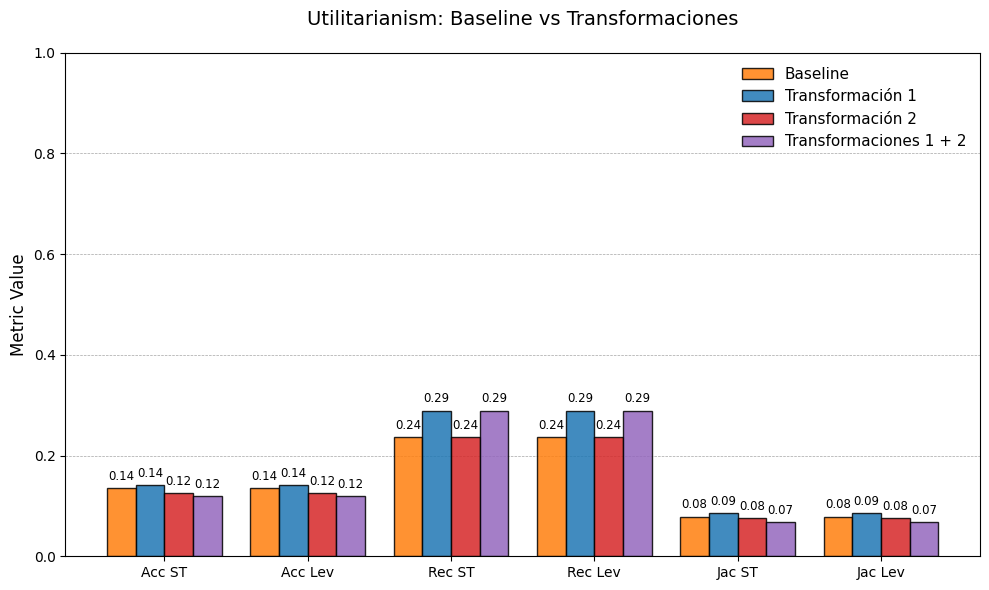

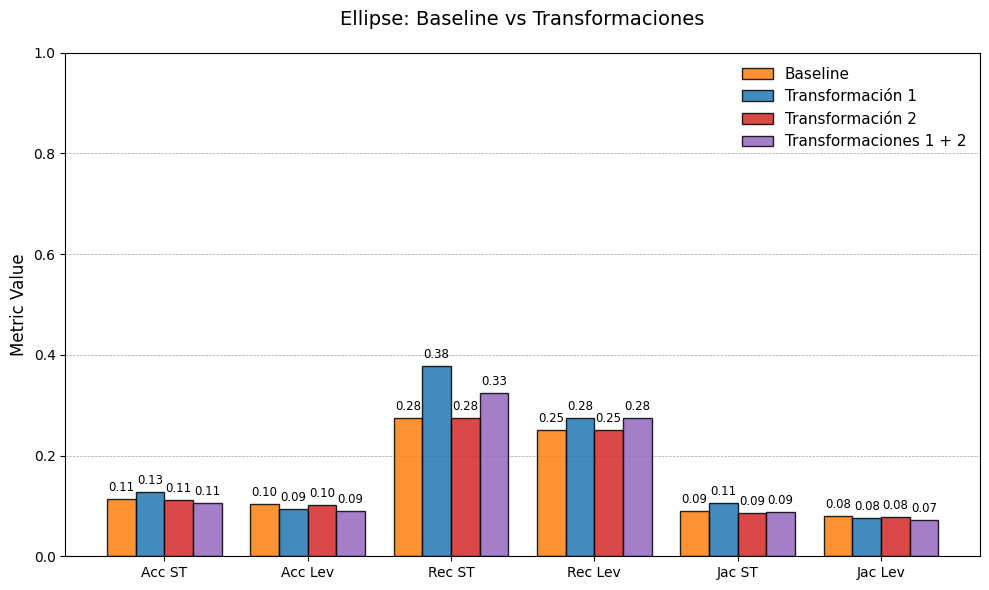

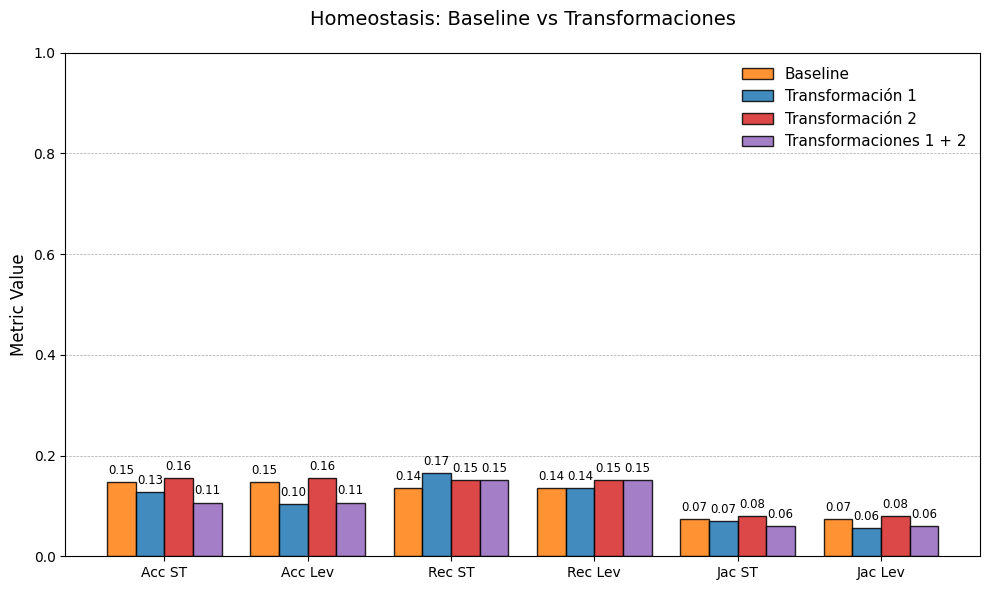

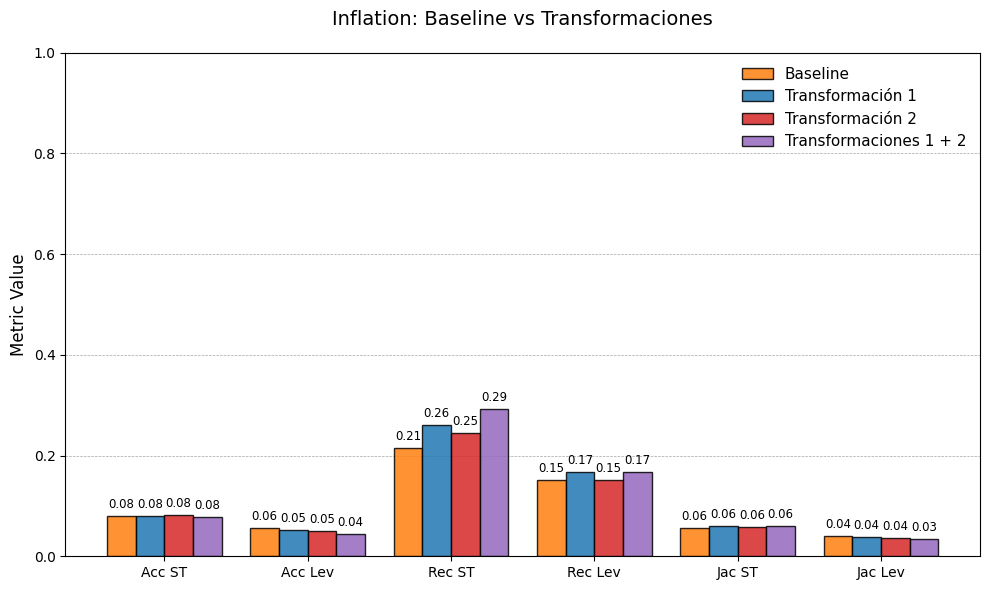

In [39]:
custom_colors = ['#ff7f0e', '#1f77b4', '#d62728', '#9467bd']

plot_comparison_bars(df_utilitarianism, "Utilitarianism: Baseline vs Transformaciones", colors=custom_colors)
plot_comparison_bars(df_ellipse, "Ellipse: Baseline vs Transformaciones", colors=custom_colors)
plot_comparison_bars(df_homeostasis, "Homeostasis: Baseline vs Transformaciones", colors=custom_colors)
plot_comparison_bars(df_inflation, "Inflation: Baseline vs Transformaciones", colors=custom_colors)

#### Evolución media de métricas

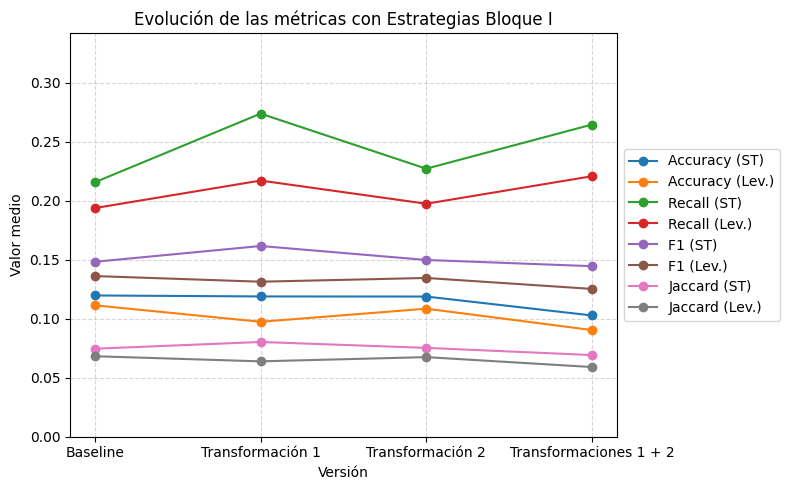

In [40]:
df_all = pd.concat([
    df_utilitarianism.assign(texto="Utilitarianism"),
    df_ellipse.assign(texto="Ellipse"),
    df_homeostasis.assign(texto="Homeostasis"),
    df_inflation.assign(texto="Inflation"),
], ignore_index=True)

df_summary = df_all.groupby("versión")[
    ["accuracy_ST","accuracy_Levenshtein",
     "recall_ST","recall_Levenshtein",
     "f1_ST", "f1_Levenshtein",
     "jaccard_ST","jaccard_Levenshtein"]
].mean().reset_index()

order=['Baseline','Transformación 1','Transformación 2','Transformaciones 1 + 2']
df_summary=df_summary.set_index('versión').loc[order].reset_index()

metrics = [
    "accuracy_ST",
    "accuracy_Levenshtein",
    "recall_ST",
    "recall_Levenshtein",
    "f1_ST",
    "f1_Levenshtein",
    "jaccard_ST",
    "jaccard_Levenshtein"
]

labels = [
    "Accuracy (ST)",
    "Accuracy (Lev.)",
    "Recall (ST)",
    "Recall (Lev.)",
    "F1 (ST)",
    "F1 (Lev.)",
    "Jaccard (ST)",
    "Jaccard (Lev.)"
]

max_val = df_summary[metrics].max().max()

plt.figure(figsize=(8, 5))
for m, lbl in zip(metrics, labels):
    plt.plot(df_summary["versión"], df_summary[m], marker="o", label=lbl)

plt.ylim(0, max_val * 1.25)
plt.xlabel("Versión")
plt.ylabel("Valor medio")
plt.title("Evolución de las métricas con Estrategias Bloque I")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

In [41]:
df_summary

,versión,accuracy_ST,accuracy_Levenshtein,recall_ST,recall_Levenshtein,f1_ST,f1_Levenshtein,jaccard_ST,jaccard_Levenshtein
0,Baseline,0.119662,0.111311,0.215562,0.193687,0.148185,0.136105,0.074537,0.068183
1,Transformación 1,0.118827,0.097360,0.273709,0.217001,0.161555,0.131310,0.080267,0.063844
2,Transformación 2,0.118743,0.108460,0.227051,0.197364,0.149736,0.134484,0.075267,0.067432
3,Transformaciones 1 + 2,0.102727,0.090364,0.264428,0.220678,0.144467,0.125222,0.069168,0.059024


In [42]:
to_save = {
    'utilitarianism_bloque_I_evaluation.csv': df_utilitarianism,
    'ellipse_bloque_I_evaluation.csv':        df_ellipse,
    'homeostasis_bloque_I_evaluation.csv':    df_homeostasis,
    'inflation_bloque_I_evaluation.csv':      df_inflation,
    'summary_bloque_I_evaluation.csv':        df_summary,
}

for filename, df in to_save.items():
    df.to_csv(filename, index=False)
    print(f"Guardado: {filename}")

Guardado: utilitarianism_bloque_I_evaluation.csv
Guardado: ellipse_bloque_I_evaluation.csv
Guardado: homeostasis_bloque_I_evaluation.csv
Guardado: inflation_bloque_I_evaluation.csv
Guardado: summary_bloque_I_evaluation.csv
